In [ ]:
# Importing necessary libraries for training and visualization
import numpy as np
import os
import pandas as pd
import torch
import torchvision
import io
from time import time
from PIL import Image
from google.colab import files, drive
from pathlib import Path
from skimage import io as sio
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import matplotlib.pyplot as plt
import tqdm

In [ ]:
class SeedDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    temp_df = pd.read_csv(csv_file)
    self.annotations = temp_df.sample(frac=1).reset_index(drop=True)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    img_id = self.annotations.iloc[index, 0]
    img = Image.open(os.path.join(self.root_dir, img_id)).convert('RGB')
    y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

    if self.transform is not None:
      img = self.transform(img)
    
    return (img, int(y_label))

In [ ]:
drive.mount('/content/gdrive')
!unzip -uq "/content/gdrive/MyDrive/seedpics.zip" -d "/content/gdrive/MyDrive/seedpics"

Mounted at /content/gdrive


In [ ]:
mean = (0.485, 0.456, 0.446)
std_dev = (0.229, 0.224, 0.225)
image_size = 200
batch_size = 32

csv_file = "/content/gdrive/MyDrive/trainlist.csv"
root_dir = "/content/gdrive/MyDrive/seedpics"

# Define transform
transform = transforms.Compose([transforms.Resize((image_size, image_size), interpolation=2), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(mean, std_dev)])

# Make entire dataset
dataset = SeedDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Split dataset into train and validation
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [3325, 713, 712])

# Create loaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape:  torch.Size([32, 3, 200, 200]) Label shape:  torch.Size([32])


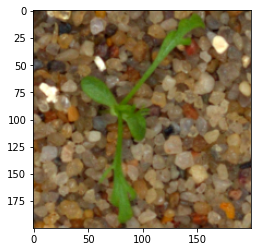

In [ ]:
# Let's visualize data from our validation to make sure it's loaded correctly.
# Each time this is run, a random sample will be viewed.
dataiter = iter(val_loader)
images, labels = dataiter.next()

# Making sure the dimensions of the image and label tensors are as expected
# is critical, since otherwise you'll be faced with a slew of dimension errors.

# We should see the image shape listed as [batch_size, channels, height, width]
# and label shape as [batch_size,]
print("Image shape: ", images.shape, "Label shape: ", labels.shape)
display = images[0] / 2.22 + 0.774 #un-normalize
display = np.transpose(display.numpy(), (1, 2, 0)) # re order channels to the back, so plotting works normally
plt.imshow(display)

In [ ]:
# Define Net structure

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.drop = nn.Dropout(0.5)
    self.relu = nn.functional.relu
    self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=2)
    self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels=96, out_channels=160, kernel_size=3, padding=1)
  
    self.fc1 = nn.Linear(5760, 2880)
    self.fc2 = nn.Linear(2880, 720)
    self.fc3 = nn.Linear(720, 12)

  def forward(self, x):
    input_size = x.size(0)

    out = self.maxpool(self.relu(self.conv1_1(x)))
    out = self.maxpool(self.relu(self.conv1_2(out)))
    out = self.maxpool(self.relu(self.conv2_1(out)))
    out = self.maxpool(self.relu(self.conv2_2(out)))

    fc_input = out.view(input_size, -1)
    out = self.relu(self.fc1(fc_input))
    out = self.drop(out)
    out = self.relu(self.fc2(out))
    out = self.drop(out)
    out = self.fc3(out)

    return out

In [ ]:
# Create network
net = Net()

# Use cross-entropy loss with the Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Function for getting accuracy, adapted from: 
# https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

def get_accuracy(loader, my_net):
  correct = 0
  total = 0
  for images, labels in loader:
      images = Variable(images)
      outputs = my_net(images)
      _, predicted = torch.max(outputs.data, 1)  
      total += labels.size(0)               
      correct += (predicted == labels).sum()
  return 100 * correct / total

In [ ]:
for images, labels in train_loader:
  images = Variable(images)

  test_tensor = net(images)
  print(test_tensor.size())
  break

torch.Size([32, 12])


In [ ]:
# Training loop w/ specified number of passes through the data
num_passes = 100

loss_values = []
val_loss = []

val_tracker = []
train_tracker = []

epoch_count = 0

#Training loop
for p in range(num_passes):
  epoch_count += 1

  #Initialize at random value
  loss = torch.tensor([100])
  running_loss = 0.0
  val_loss_run = 0.0

  #Set up visuals for training
  progress_bar = tqdm.notebook.tqdm(train_loader, ncols=1000)

  #Batch loop
  for i, (images, labels) in enumerate(progress_bar):

    images = Variable(images)
    labels = Variable(labels)

    if i==0:
      print("Epoch #%d, size = %d" % (epoch_count, images.size(0))) # to keep track of epochs
    
    #Clear gradient
    optimizer.zero_grad()
    #Perform forward pass (net calls the forward function)
    outputs = net(images)
    #Compute loss on output
    loss = criterion(outputs, labels)
    #Compute new gradients using the loss, then update weights through backprop
    loss.backward()
    optimizer.step()

    #For graphing purposes:
    running_loss =+ loss.item() * images.size(0)
    val_loss_run =+ loss.item() * images.size(0)

    # Visualization code:
    if (i+1) % 100 == 0 or (i+1) == len(train_loader): 
      val_acc_temp = get_accuracy(val_loader, net)
      progress_bar.set_description('Epoch [%d/%d], Step [%d/%d], Val Acc: %d, Training Loss: %.4f'
              %(p+1, num_passes, i+1, len(train_loader), \
                val_acc_temp, loss.data))

  val_acc = get_accuracy(val_loader, net)
  train_acc = get_accuracy(train_loader, net)
  val_tracker.append(val_acc)
  train_tracker.append(train_acc)    
  loss_values.append(running_loss / len(train_set))
  val_loss.append(val_loss_run/len(val_set))

# Print the training and test accuracy
train_acc = get_accuracy(train_loader, net)
test_acc = get_accuracy(test_loader, net)

print('Final training accuracy: %d %%' % (train_acc))
print('Testing accuracy: %d %%' % (test_acc))


Epoch #1, size = 32



Epoch #2, size = 32



Epoch #3, size = 32



Epoch #4, size = 32



Epoch #5, size = 32



Epoch #6, size = 32



Epoch #7, size = 32



Epoch #8, size = 32



Epoch #9, size = 32



Epoch #10, size = 32



Epoch #11, size = 32



Epoch #12, size = 32



Epoch #13, size = 32



Epoch #14, size = 32



Epoch #15, size = 32



Epoch #16, size = 32



Epoch #17, size = 32



Epoch #18, size = 32



Epoch #19, size = 32



Epoch #20, size = 32



Epoch #21, size = 32



Epoch #22, size = 32



Epoch #23, size = 32



Epoch #24, size = 32



Epoch #25, size = 32



Epoch #26, size = 32



Epoch #27, size = 32



Epoch #28, size = 32



Epoch #29, size = 32



Epoch #30, size = 32



Epoch #31, size = 32



Epoch #32, size = 32



Epoch #33, size = 32



Epoch #34, size = 32



Epoch #35, size = 32



Epoch #36, size = 32



Epoch #37, size = 32



Epoch #38, size = 32



Epoch #39, size = 32



Epoch #40, size = 32



Epoch #41, size = 32



Epoch #42, size = 32



Epoch #43, size = 32



Epoch #44, size = 32



Epoch #45, size = 32



Epoch #46, size = 32



Epoch #47, size = 32



Epoch #48, size = 32



Epoch #49, size = 32



Epoch #50, size = 32



Epoch #51, size = 32



Epoch #52, size = 32



Epoch #53, size = 32



Epoch #54, size = 32



Epoch #55, size = 32



Epoch #56, size = 32



Epoch #57, size = 32



Epoch #58, size = 32



Epoch #59, size = 32



Epoch #60, size = 32



Epoch #61, size = 32



Epoch #62, size = 32



Epoch #63, size = 32



Epoch #64, size = 32



Epoch #65, size = 32



Epoch #66, size = 32



Epoch #67, size = 32



Epoch #68, size = 32



Epoch #69, size = 32



Epoch #70, size = 32



Epoch #71, size = 32



Epoch #72, size = 32



Epoch #73, size = 32



Epoch #74, size = 32



Epoch #75, size = 32



Epoch #76, size = 32



Epoch #77, size = 32



Epoch #78, size = 32



Epoch #79, size = 32



Epoch #80, size = 32



Epoch #81, size = 32



Epoch #82, size = 32



Epoch #83, size = 32



Epoch #84, size = 32



Epoch #85, size = 32



Epoch #86, size = 32



Epoch #87, size = 32



Epoch #88, size = 32



Epoch #89, size = 32



Epoch #90, size = 32



Epoch #91, size = 32



Epoch #92, size = 32



Epoch #93, size = 32



Epoch #94, size = 32



Epoch #95, size = 32



Epoch #96, size = 32



Epoch #97, size = 32



Epoch #98, size = 32



Epoch #99, size = 32



Epoch #100, size = 32

Final training accuracy: 97 %
Testing accuracy: 90 %


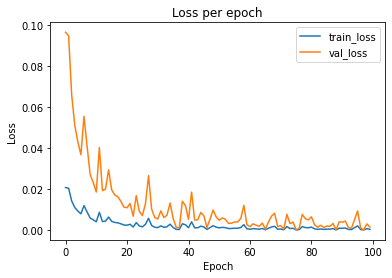

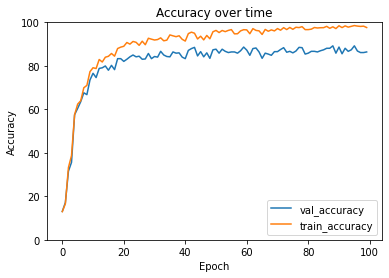

In [ ]:
# Plot the loss over time
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss per epoch")
plt.plot(loss_values, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

# Plot the accuracy over time
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim([0,100])
plt.title("Accuracy over time")
plt.plot(val_tracker, label='val_accuracy')
plt.plot(train_tracker, label='train_accuracy')
plt.legend()
plt.show()